# Forex Pairs Trading Strategy Implementation

Implementation of the cointegration-based pairs trading strategy following the paper methodology.

## Paper Methodology
1. **Rolling Window Approach**: Test cointegration on training windows (63, 128, 257 days)
2. **Mean-Reversion Strategy**: Generate z-score signals if cointegration is found
3. **Parameter Optimization**: Test different combinations of:
   - Training windows: 63, 128, 257 days
   - Testing windows: 1, 5, 21, 63, 128 days  
   - Z-score thresholds: ±1, ±2, ±3
4. **Performance Evaluation**: Calculate risk-adjusted returns for all combinations

## Steps
1. Setup rolling window framework
2. Implement cointegration testing on training windows
3. Generate trading signals based on z-scores
4. Backtest all parameter combinations
5. Performance analysis and ranking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from itertools import permutations
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
import sys
sys.path.append('../')
from config import (CURRENCY_PAIRS, TRAINING_WINDOWS, TESTING_WINDOWS, 
                   Z_SCORE_THRESHOLDS, SIGNIFICANCE_LEVEL, RISK_FREE_RATE, 
                   HOLDING_THRESHOLD, STOP_LOSS, TAKE_PROFIT, TRANSACTION_COSTS)

# Display settings
plt.style.use('seaborn-v0_8')

In [2]:
# Load transformed forex data
forex_data = pd.read_csv('../data/forex_data.csv', index_col=0, parse_dates=True)
log_data = np.log(forex_data)

In [3]:
def cointegration_test(x_log, y_log, significance_level=SIGNIFICANCE_LEVEL):
    """
    Perform the Engle-Granger cointegration test on two log-transformed time series.

    Parameters:
    - x_log: Log-transformed first time series (array-like or pd.Series).
    - y_log: Log-transformed second time series (array-like or pd.Series).
    - significance_level: Significance level for the ADF tests.

    Returns:
    - bool: True if the series are cointegrated, False otherwise.
    - float: Cointegration coefficient (alpha) from the linear regression.
    - float: Intercept from the linear regression.
    """

    # Check individual stationarity
    x_adf = adfuller(x_log)[1]
    y_adf = adfuller(y_log)[1]
    if x_adf < significance_level or y_adf < significance_level:
        return False, 0, 0  # Return False if either series is not stationary
    # Perform cointegration test
    x_val = pd.DataFrame(x_log)
    y_val = y_log
    reg = LinearRegression(fit_intercept = True)
    reg.fit(x_val,y_val)
    alpha = reg.coef_[0]
    intercept = reg.intercept_
    prediction = reg.predict(x_val)
    res = y_val - prediction
    # Perform ADF test on residuals
    adfuller_result = adfuller(res)
    return (adfuller_result[1] < significance_level), alpha, intercept

In [4]:
def calculate_spread(x, y, alpha, intercept):
    """
    Calculate the spread between two series using the cointegration coefficient and intercept.

    Parameters:
    - x: First time series (array-like).
    - y: Second time series (array-like).
    - alpha: Cointegration coefficient from the regression.
    - intercept: Intercept from the regression.

    Returns:
    - np.ndarray: Spread series calculated as y - (alpha * x + intercept).
    """

    x = np.array(x)
    y = np.array(y)
    
    return y - (alpha * x + intercept)

In [5]:
def calculate_z_score(spread, mean_spread, std_spread):
    """
    Calculate the Z-score of the spread series.

    Parameters:
    - spread: The spread series (array-like or float).
    - mean_spread: Mean of the spread.
    - std_spread: Standard deviation of the spread.

    Returns:
    - float or np.ndarray: Z-score of the spread.
    """

    return (spread - mean_spread) / std_spread

In [6]:
def generate_signal(z_score, z_score_threshold):
    """
    Generate trading signals based on the Z-score and a predefined threshold.

    Parameters:
    - z_score: Z-score of the spread (float).
    - z_score_threshold: Threshold for signal generation (float).

    Returns:
    - int: Trading signal. 1 for long, -1 for short, 0 for no position.
    """

    if z_score > z_score_threshold:
        return -1  # Short signal
    elif z_score < -z_score_threshold:
        return 1   # Long signal
    else:
        return 0   # No signal

In [7]:
def close_position(position, z_score, holding_period, holding_threshold=None, 
                    position_returns=None, stop_loss=None, take_profit=None):
    """
    Determine whether to close the current trading position based on the Z-score.

    Parameters:
    - position: Current position (1 for long, -1 for short).
    - z_score: Current Z-score of the spread.
    - holding_period: Number of days the position has been held.
    - holding_threshold: Optional threshold for holding period (in days).
    - position_returns: Current returns from the position.
    - stop_loss: Optional stop loss value for the position.
    - take_profit: Optional take profit value for the position.

    Returns:
    - bool: True if the position should be closed, False otherwise.
    """
    # Check stop loss and take profit conditions
    if stop_loss is not None and position_returns <= -stop_loss:
        return True
    if take_profit is not None and position_returns >= take_profit:
        return True

    # Holding period logic
    if holding_threshold is not None:
        # Check if the holding period exceeds the threshold
        if holding_period >= holding_threshold:
            return True

    if position == 1 and z_score >= 0:  # Long position
        return True
    
    elif position == -1 and z_score <= 0:  # Short position
        return True
    
    return False  # Do not close the position

In [8]:
def backtest(pair, training_window, testing_window, z_score_threshold, holding_threshold,
             stop_loss, take_profit, transaction_costs):
    """
    Backtest a pairs trading strategy on a given currency pair using rolling windows and a maximum holding period.

    Parameters:
    - pair: Tuple of strings representing the two currency names (e.g., ('EURUSD', 'GBPUSD')).
    - training_window: Number of observations used for training in each rolling window.
    - testing_window: Number of observations used for testing in each rolling window.
    - z_score_threshold: Z-score threshold used to generate trading signals.
    - holding_threshold: Maximum number of days to hold a position before forcibly closing it.
    - stop_loss: Stop-loss threshold for closing positions.
    - take_profit: Take-profit threshold for closing positions.
    - transaction_costs: Transaction costs incurred for opening/closing positions.

    Returns:
    - list: List of returns generated during the backtest period.
    """

    x_name, y_name = pair
    x_log = log_data[x_name]
    y_log = log_data[y_name]

    # Split data into training and testing sets
    train_start = 0
    train_end = training_window
    test_start = training_window
    test_end = test_start + testing_window

    all_returns = []
    position = 0
    holding_period = 0

    # For stop-loss and take-profit
    position_returns = 0.0


    while test_end <= len(x_log):
        # Extract training and testing data
        x_train = x_log[train_start:train_end]
        y_train = y_log[train_start:train_end]
        x_test = x_log[test_start:test_end]
        y_test = y_log[test_start:test_end]

        # Perform cointegration test
        is_cointegrated, alpha, intercept = cointegration_test(x_train, y_train)

        # Calculate spread and Z-score for training data
        spread_train = calculate_spread(x_train, y_train, alpha, intercept)
        mean_spread = spread_train.mean()
        std_spread = spread_train.std()

        
        if not is_cointegrated:
            all_returns.extend([0.0] * testing_window) # No returns if not cointegrated
        else:
            for t in range(testing_window):
                current_day = test_start + t

                # Skip first day
                if current_day <= 0:
                    all_returns.append(0.0)
                    continue

                x_t = x_log[current_day]
                y_t = y_log[current_day]
                x_t_1 = x_log[current_day - 1]
                y_t_1 = y_log[current_day - 1]

                # Calculate spread and Z-score
                spread_t_1 = calculate_spread(x_t_1, y_t_1, alpha, intercept) # Calculate spread for the previous day
                spread_t = calculate_spread(x_t, y_t, alpha, intercept) # Calculate spread for the current day
                z_score = calculate_z_score(spread_t_1, mean_spread, std_spread) # Calculate Z-score for the previous day

                # Generate trading signal
                signal = generate_signal(z_score, z_score_threshold)

                if position == 0:
                    if signal == 1: # Open long position
                        position = 1
                        holding_period = 1
                        position_returns = - transaction_costs
                        all_returns.append(-transaction_costs)  # No return on the first day of the position
                    elif signal == -1: # Open short position
                        position = -1
                        holding_period = 1
                        position_returns = - transaction_costs
                        all_returns.append(-transaction_costs)  # No return on the first day of the position
                    else:  # No position
                        all_returns.append(0.0) # No open position, no return

                elif position == 1:  # Long position
                    if close_position(position, z_score, holding_period, holding_threshold,
                                    position_returns, stop_loss, take_profit):
                        position = 0
                        #print(f"Closing long position on {current_day} with z-score {z_score:.2f}")
                        holding_period = 0
                        position_returns = 0.0
                        all_returns.append(spread_t - spread_t_1 - transaction_costs)
                    else:
                        holding_period += 1
                        position_returns += spread_t - spread_t_1
                        all_returns.append(spread_t - spread_t_1)  # Calculate return on closing position

                elif position == -1:  # Short position
                    if close_position(position, z_score, holding_period, holding_threshold,
                                    position_returns, stop_loss, take_profit):
                        position = 0
                        #print(f"Closing short position on {current_day} with z-score {z_score:.2f}")
                        holding_period = 0
                        position_returns = 0.0
                        all_returns.append(spread_t_1 - spread_t - transaction_costs)
                    else:
                        holding_period += 1
                        position_returns += spread_t_1 - spread_t
                        all_returns.append(spread_t_1 - spread_t)  # Calculate return on closing position

        # Shift the windows
        train_start += testing_window
        train_end += testing_window
        test_start += testing_window
        test_end += testing_window

    return all_returns


In [9]:
def calculate_metrics(returns):
    """
    Calculate risk-adjusted performance metrics from daily log returns.

    Parameters:
    - returns: array-like. Daily log returns of the strategy or asset.

    Returns:
    - dict: Dictionary containing the following metrics:
        - ann_ret: Annualised expected return (log).
        - ann_std_ret: Annualised standard deviation (volatility).
        - sharpe: Sharpe ratio (excess return over volatility).
        - sortino: Sortino ratio (excess return over downside deviation).
        - max_drawdown: Maximum drawdown (absolute value).
        - calmar: Calmar ratio (return over max drawdown).
    """
    ann_ret = np.mean(returns) * 252

    ann_std_ret = np.std(returns, ddof = 1) * np.sqrt(252)

    sharpe = (ann_ret - RISK_FREE_RATE) / ann_std_ret

    target = RISK_FREE_RATE / 252
    neg_ret = returns[returns < target]
    ann_std_down = np.sqrt(np.mean((neg_ret - target)**2)) * np.sqrt(252)
    sortino = (ann_ret - RISK_FREE_RATE) / ann_std_down

    cum_returns = np.exp(np.cumsum(returns))
    rolling_max = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - rolling_max) / rolling_max
    max_drawdown = abs(np.min(drawdowns))

    calmar = ann_ret / max_drawdown

    return {
        "ann_ret": ann_ret,
        "ann_std_ret": ann_std_ret,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_drawdown,
        "calmar": calmar
    }

In [10]:
def run_full_backtest(TRAINING_WINDOWS = TRAINING_WINDOWS, TESTING_WINDOWS = TESTING_WINDOWS,
                        Z_SCORE_THRESHOLDS = Z_SCORE_THRESHOLDS, HOLDING_THRESHOLD = HOLDING_THRESHOLD,
                        STOP_LOSS = STOP_LOSS, TAKE_PROFIT = TAKE_PROFIT, TRANSACTION_COSTS = TRANSACTION_COSTS):
    """
    Run a full grid search backtest across all combinations of hyperparameters.

    Parameters:
    - TRAINING_WINDOWS: List of integers representing different training window sizes.
    - TESTING_WINDOWS: List of integers representing different testing window sizes.
    - Z_SCORE_THRESHOLDS: List of floats representing Z-score thresholds for trading signal generation.
    - HOLDING_THRESHOLD: Integer indicating the maximum number of days to hold a position before closing it.
    - STOP_LOSS: Stop-loss threshold for closing positions.
    - TAKE_PROFIT: Take-profit threshold for closing positions.
    - TRANSACTION_COSTS: Transaction costs incurred for opening/closing positions.

    Returns:
    - pd.DataFrame: DataFrame containing the results for each parameter combination, including trading performance metrics and returns.
    """

    currency_pairs = list(permutations(log_data.columns, 2))
    results = []
    
    # Total iterations
    total_iterations = len(TRAINING_WINDOWS) * len(TESTING_WINDOWS) * len(Z_SCORE_THRESHOLDS) * len(currency_pairs)
    
    # Progress bar
    with tqdm(total = total_iterations, desc = "Running backtest") as pbar:
        for train_w in TRAINING_WINDOWS:
            for test_w in TESTING_WINDOWS:
                for z_thresh in Z_SCORE_THRESHOLDS:
                    for pair in currency_pairs:
                        # Update description
                        pbar.set_postfix({
                            'train': train_w, 'test': test_w, 
                            'z': z_thresh, 'pair': f"{pair[0]}-{pair[1]}"
                        })
                        
                        # Run backtest
                        returns = np.array(backtest(pair, train_w, test_w, z_thresh, HOLDING_THRESHOLD,
                                                    STOP_LOSS, TAKE_PROFIT, TRANSACTION_COSTS))

                        # Calculate metrics
                        metrics = calculate_metrics(returns)
                        
                        # Save results
                        results.append({
                            'pair': pair,
                            'train_window': train_w,
                            'test_window': test_w,
                            'z_threshold': z_thresh,
                            'returns': returns,
                            **metrics  # Unpack metrics dictionary
                        })
                        
                        # Update bar
                        pbar.update(1)
    
    return pd.DataFrame(results)

In [11]:
# Run backtest
TRAINING_WINDOWS = [257]  # days
TESTING_WINDOWS = [21]  # days
Z_SCORE_THRESHOLDS = [3]  # standard deviations

STOP_LOSS = 0.07  # 7% stop-loss

TRANSACTION_COSTS = 0.0005  # 0.05% transaction costs

results_df = run_full_backtest(TRAINING_WINDOWS, TESTING_WINDOWS, Z_SCORE_THRESHOLDS,
                                HOLDING_THRESHOLD, STOP_LOSS, TAKE_PROFIT, TRANSACTION_COSTS)

Running backtest: 100%|██████████| 42/42 [01:04<00:00,  1.54s/it, train=257, test=21, z=3, pair=NZDUSD-AUDUSD]


In [12]:
def analyze_top_strategies(results_df, top_ns=[5, 10, 20, 30], plot=True):
    """
    Analyze and aggregate performance metrics for the top-N strategies based on Sharpe ratio.

    Parameters:
    - results_df: DataFrame containing strategy results, including 'returns' and 'sharpe' columns.
    - top_ns: List of integers representing the top-N strategies to evaluate (default: [5, 10, 20, 30]).
    - plot: Boolean indicating whether to display cumulative return plots (default: True).

    Returns:
    - pd.DataFrame: Aggregated performance metrics for each top-N group.
    - dict: Dictionary mapping each N to its corresponding cumulative return curve.
    """

    aggregated_metrics = {}
    cumulative_curves = {}

    for n in top_ns:
        top_n = results_df.sort_values("sharpe", ascending=False).head(n)
        returns_matrix = np.vstack(top_n["returns"].values)
        agg_returns = np.mean(returns_matrix, axis=0)
        
        metrics = calculate_metrics(agg_returns)
        aggregated_metrics[n] = metrics
        cumulative_curves[n] = np.exp(np.cumsum(agg_returns))

    agg_df = pd.DataFrame(aggregated_metrics).T

    if plot:
        plt.figure(figsize=(10, 6))
        for n, curve in cumulative_curves.items():
            plt.plot(curve, label=f"Top {n}")
        plt.title("Standardized Cumulative Returns (Top-N Strategies)")
        plt.xlabel("Days")
        plt.ylabel("Cumulative Return")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return agg_df, cumulative_curves

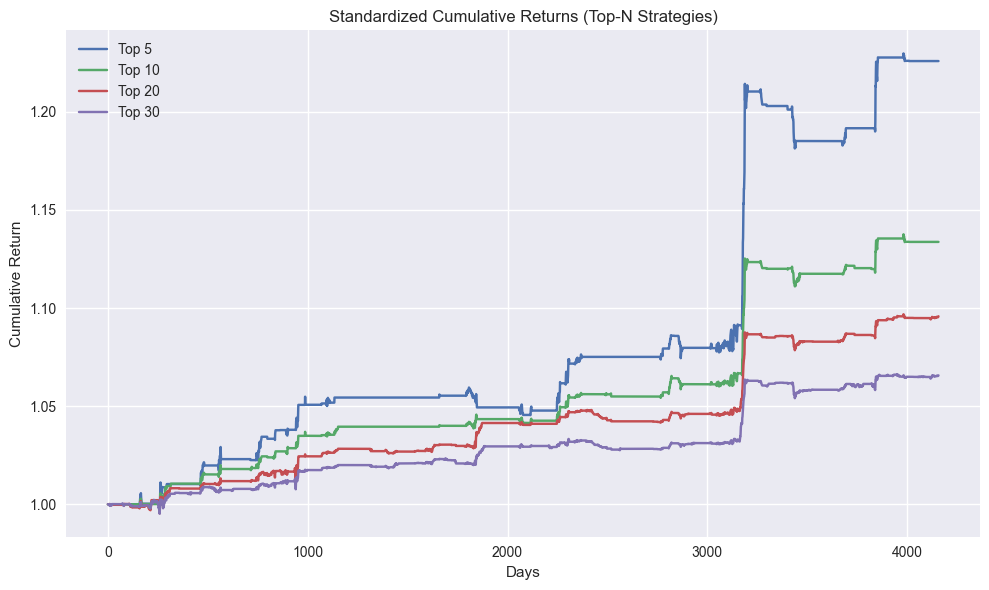

     ann_ret  ann_std_ret    sharpe   sortino  max_drawdown    calmar
5   0.012342     0.013629  0.905568  0.573210      0.027120  0.455107
10  0.007605     0.007110  1.069644  0.703669      0.012613  0.602951
20  0.005543     0.005376  1.031209  0.783194      0.008375  0.661846
30  0.003855     0.004410  0.874123  0.715883      0.008944  0.430965


In [13]:
agg_metrics_df, curves = analyze_top_strategies(results_df)
print(agg_metrics_df)